# Energy Demand Forecasting - EDA and ML Try I

## Packages

In [1]:
# psycopg2: python package to deal with a postgres database
# pip install psycopg2
import psycopg2
from psycopg2.extras import execute_values

In [7]:
import numpy as np
import pandas as pd
import warnings

from datetime import datetime, timedelta

import urllib.request
import json

# Librería para obtener el usuario que está ejecutando el script
import getpass

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#import matplotlib.dates as mdates

import traceback

#import hashlib

warnings.filterwarnings("ignore", category=Warning)
# Seteos de Pandas para ver mejor la info. https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
# In max_columns and max_rows ‘None’ value means unlimited.
pd.set_option('display.max_rows', 100)
# Conviene setear min_rows también porque cuando se superan las max_rows, sólo muestra la cantidad indicada en min_rows.
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.0f}'.format

## Funciones Soporte

In [3]:
def build_postgres_cnxn(database, host, user, password, port=5432, string_connection=None, verbose=True):
    error_txt = ''
    process_ok = True
    cnxn = None
    cursor = None
    if (not host or not user or not password) and not string_connection:
        process_ok = False
        error_txt = 'ERROR build_postgres_cnxn: Error trying to Build DB connexion: you missed to send host, user or password, or string connection. ' +\
                    ' host: ' + (host if host else 'Missed. ') +\
                    ' user: ' + (user if user else 'Missed.') +\
                    ' password: ' + (password if password else 'Missed.') +\
                    ' String Connection: ' + (string_connection if string_connection else 'Missed.')
        if verbose:
            print(error_txt)
    else:
        if not database:
            if verbose:
                print('WARNING build_postgres_cnxn: no database name provided.')
        try:
            if not string_connection:
                cnxn = psycopg2.connect(database=database, host=host, user=user, password=password, port=port)
            else:
                cnxn = psycopg2.connect(string_connection)
            cursor = cnxn.cursor()
            if verbose:
                print('INFO Module build_postgres_cnxn: DB Connection to host', host, 'Ok')
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            if not string_connection:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database host: ' + host + ' user ' +\
                      user + ' port: ' + str(port) +'\n' + txt)
            else:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database string_connection: ' + string_connection +'\n' + txt)
    return process_ok, error_txt, cnxn, cursor

In [4]:
def pg_select_to_pandas(cursor, sql_query, verbose=True):
    error_txt = ''
    process_ok = True
    df = pd.DataFrame()
    if (not cursor or not sql_query):
        process_ok = False
        error_txt = 'ERROR pg_select_to_pandas: No cursor or Query sent as parameter. ' +\
              ' cursor: ' + (' received.' if cursor else ' missed,') +\
              ' query: ' + (sql_query if sql_query else ' missed.')
        if verbose:
            print(error_txt)
    else:
        try:
            cursor.execute(sql_query)
            data = cursor.fetchall()
            colnames = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(data=data, columns=colnames)
            if verbose:
                print('INFO pg_select_to_pandas: query executed Ok. Number of records returned: ' + str(df.shape[0]))
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            error_txt = 'ERROR pg_select_to_pandas: Error executing query on host: ' + cursor.connection.info.host + ' database ' +\
                  cursor.connection.info.dbname + ' query: ' + sql_query +'\n' + txt
            if verbose:
                print(error_txt)
    return process_ok, error_txt, df

In [5]:
def plot_df(df_, time_since, time_until, time_col, left_feat_lst, right_feat_lst, title="", xposition=[], yposition=[]
    , fig_size=[10, 3], return_df=True):
    """Plot a spot in the timeline of an element
        PARAMS:
        df_: dataframe source of data (must have fields "ts")
        ts *: timestamp column in df_
        time_since *: ts start of period to plot
        time_until *: ts end of period to plot
        left_feat_lst *: list of dataframe features to plot using left axis
        right_feat_lst *: list of dataframe features to plot using right axis
        xposition: list of vertical lines to draw
    """
    colors_lst=['deepskyblue', 'skyblue', 'steelblue', 'dodgerblue', 'indianred', 'firebrick', 'marron', 'lightsalmon', 'darkorange', 'orange']
    fig, ax = plt.subplots()
    df_plot = df_[(df_[time_col].between(time_since, time_until))]
    for idx, feat in enumerate(left_feat_lst):
        df_plot.plot(x=time_col, y=feat, ax=ax, style='-', color=colors_lst[idx], figsize=(fig_size[0], fig_size[1]))
    i=idx+1
    for idx, feat in enumerate(right_feat_lst):
        df_plot.plot(x=time_col, y=feat, ax=ax, style='--', color=colors_lst[i+idx], figsize=(fig_size[0], fig_size[1])
            , secondary_y=True, lw=1)
    plt.title(title)
   
    # same ax as above since it's automatically added on the right
    #df_plot.plot(x='ts', y='rpm', ax=ax, style='r-', secondary_y=True);
    #ax.set_ylim([0, 40]);
    for xc in xposition:
        ax.axvline(x=xc, color='r', linestyle='--', lw=1);
    for yc in yposition:
        ax.axhline(y=yc, color='r', linestyle='--', lw=1);
    return df_plot if return_df else np.nan

In [ ]:
n_lookback = 48
last_timestamp = datetime(2022, 11, 6, 9, 00)
sql_query = """SELECT timestamp, hourly_demand, hourly_temp, day_of_week, is_holiday 
                        FROM cammesa_db.hourly_demand 
                        WHERE timestamp >= '""" + (last_timestamp+timedelta(hours=-n_lookback)).strftime('%Y-%m-%d %H:%M') +"'" +\
                    """AND timestamp <= '""" + last_timestamp.strftime('%Y-%m-%d %H:%M') +"'"+\
                    """ORDER BY timestamp"""
cursor.execute(sql_query)
data = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
df_lookback = pd.DataFrame(data=data, columns=colnames)
df_lookback.shape[0]
conn.close()
date=datetime.now()
date.hour

# DB Data load

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 129


nan

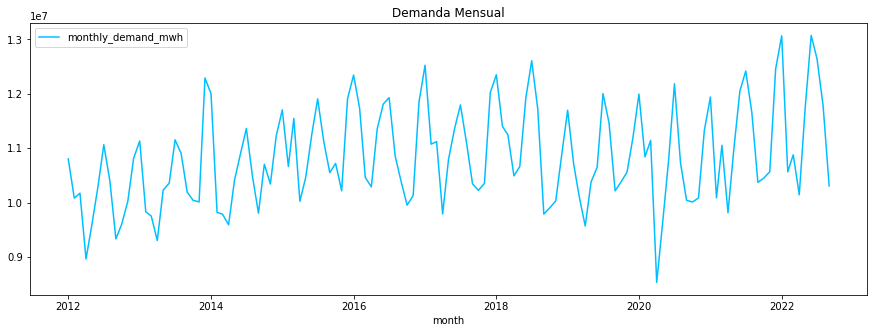

In [11]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """SELECT month, 
                sum(monthly_demand_mwh) as monthly_demand_mwh
                FROM cammesa_db.monthly_demand
                GROUP BY month
            """
process_ok, error_txt, df_demanda = pg_select_to_pandas(cursor, sql_query, verbose=True)
plot_df(df_demanda, df_demanda.month.min(), df_demanda.month.max(), 'month', ['monthly_demand_mwh'], [], title='Demanda Mensual'
    , xposition=[], yposition=[], fig_size=[15, 5], return_df=False)

In [54]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """SELECT month, 
                sum(monthly_gen_mwh) as monthly_gen_mwh
                FROM cammesa_db.monthly_gen
                GROUP BY month
            """
process_ok, error_txt, df_gen = pg_select_to_pandas(cursor, sql_query, verbose=True)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 129


In [60]:
df_dataset = df_demanda.merge(df_gen, on='month', how='left')

nan

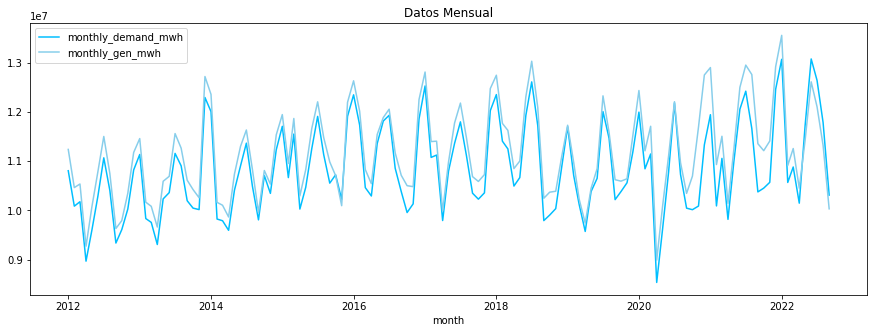

In [56]:
plot_df(df_dataset, df_dataset.month.min(), df_dataset.month.max(), 'month', ['monthly_demand_mwh', 'monthly_gen_mwh'], []
    , title='Datos Mensual'
    , xposition=[], yposition=[], fig_size=[15, 5], return_df=False)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 81


nan

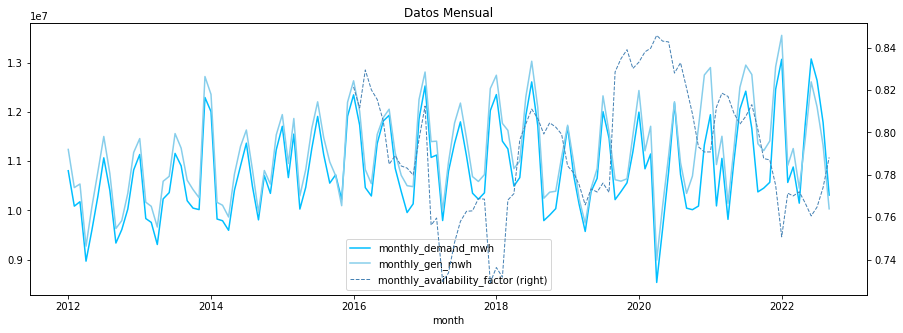

In [57]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """SELECT month, 
                avg(monthly_availability_factor) as monthly_availability_factor
                FROM cammesa_db.monthly_availability
                GROUP BY month
            """
process_ok, error_txt, df_avail = pg_select_to_pandas(cursor, sql_query, verbose=True)
df_dataset = df_demanda.merge(df_gen, on='month', how='left')
df_dataset = df_dataset.merge(df_avail, on='month', how='left')
plot_df(df_dataset, df_dataset.month.min(), df_dataset.month.max(), 'month', ['monthly_demand_mwh', 'monthly_gen_mwh']
    , ['monthly_availability_factor']
    , title='Datos Mensual'
    , xposition=[], yposition=[], fig_size=[15, 5], return_df=False)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 129


nan

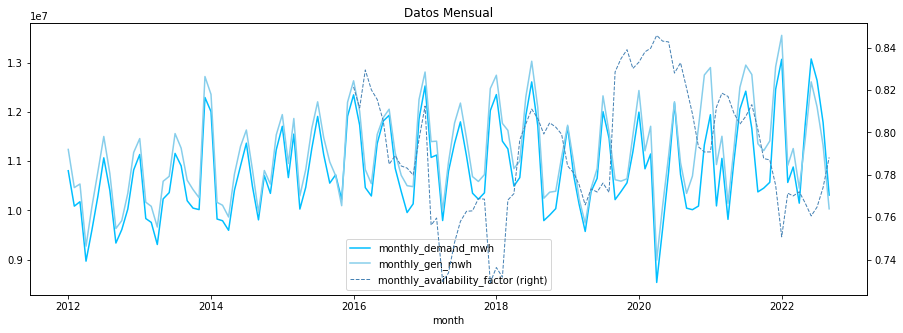

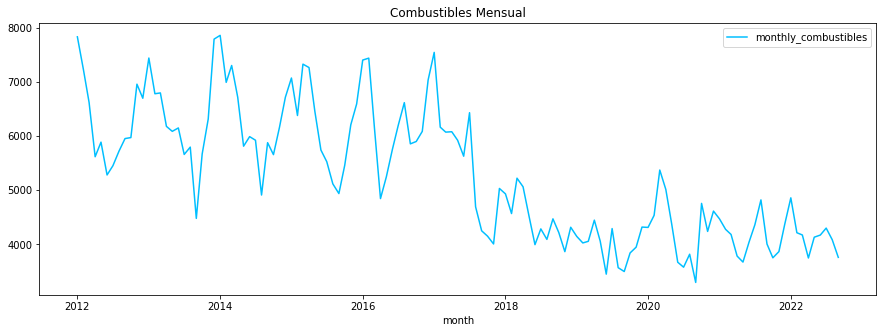

In [63]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """SELECT month, 
                avg(monthly_consume) as monthly_combustibles
                FROM cammesa_db.monthly_combustibles
                GROUP BY month
            """
process_ok, error_txt, df_combustibles = pg_select_to_pandas(cursor, sql_query, verbose=True)
df_dataset = df_demanda.merge(df_gen, on='month', how='left')
df_dataset = df_dataset.merge(df_avail, on='month', how='left')
df_dataset = df_dataset.merge(df_combustibles, on='month', how='left')
plot_df(df_dataset, df_dataset.month.min(), df_dataset.month.max(), 'month'
    , ['monthly_demand_mwh', 'monthly_gen_mwh']
    , ['monthly_availability_factor']
    , title='Datos Mensual'
    , xposition=[], yposition=[], fig_size=[15, 5], return_df=False)
plot_df(df_dataset, df_dataset.month.min(), df_dataset.month.max(), 'month'
    , ['monthly_combustibles'], []
    , title='Combustibles Mensual'
    , xposition=[], yposition=[], fig_size=[15, 5], return_df=False)

In [ ]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """SELECT month, 
                avg(monthly_consume) as monthly_combustibles
                FROM cammesa_db.monthly_combustibles
                GROUP BY month
            """
process_ok, error_txt, df_combustibles = pg_select_to_pandas(cursor, sql_query, verbose=True)
df_dataset = df_demanda.merge(df_gen, on='month', how='left')
df_dataset = df_dataset.merge(df_avail, on='month', how='left')
df_dataset = df_dataset.merge(df_combustibles, on='month', how='left')
plot_df(df_dataset, df_dataset.month.min(), df_dataset.month.max(), 'month'
    , ['monthly_demand_mwh', 'monthly_gen_mwh']
    , ['monthly_availability_factor']
    , title='Datos Mensual'
    , xposition=[], yposition=[], fig_size=[15, 5], return_df=False)
plot_df(df_dataset, df_dataset.month.min(), df_dataset.month.max(), 'month'
    , ['monthly_combustibles'], []
    , title='Combustibles Mensual'
    , xposition=[], yposition=[], fig_size=[15, 5], return_df=False)

# Estudios de Correlaciones
Primer estudio es con las variables completamente sumarizadas a nivel país. Ver correlación entre demanda, generación, precios, combustibles, availability by central (by energy type), import/export.

Pendiente caudales, que no hay historia
Cómo conseguir la temperatura??

Probar los modelos a nivel total país.

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates

# List of colors for plots
colors = ['darksalmon',  'royalblue', 'aquamarine', 'darkturquoise', 'magenta', 'maroon', 'lightslategray', 'sienna'
    , 'darkseagreen', 'ghostwhite', 'gold', 'gray', 'goldenrod', 'lightskyblue', 'silver', 'skyblue', 'salmon', 'royalblue'
    , 'saddlebrown', 'aqua', 'sandybrown', 'mediumslateblue', 'mediumaquamarine']

In [305]:
df_dem_mensual = df_demanda[['month', 'monthly_demand_mwh']].groupby('month').agg({'monthly_demand_mwh': 'sum'})
df_dem_mensual.reset_index(inplace=True)
df_gen_mensual = df_generacion[['month', 'monthly_gen_mwh']].groupby('month').agg({'monthly_gen_mwh': 'sum'})
df_gen_mensual.reset_index(inplace=True)
df_precios_mensual = df_precios[['month', 'energia', 'energia_ad'
    , 'carg_dem_exce_cta_brasil_contrat_abas_MEM', 'cargo_demanda_exced_real', 'cta_brasil_abast_MEM'
    , 'monodico', 'monodico_transp', 'monodico_ponder_estacional_otr_ingr', 'monodico_ponder_estacional_transp']]

df_dataset = df_dem_mensual.merge(df_gen_mensual, on='month', how='left')
df_dataset = df_dataset.merge(df_precios_mensual, on='month', how='left')
df_dataset

,month,monthly_demand_mwh,monthly_gen_mwh,energia,energia_ad,carg_dem_exce_cta_brasil_contrat_abas_MEM,cargo_demanda_exced_real,cta_brasil_abast_MEM,monodico,monodico_transp,monodico_ponder_estacional_otr_ingr,monodico_ponder_estacional_transp
0,2012-01-01,10804700,11236939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-02-01,10085552,10462376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-03-01,10175365,10535239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-04-01,8969068,9273244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-05-01,9597272,10069749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
124,2022-05-01,11726718,11426545,930,282,147,11947,4178,5,99,56,0
125,2022-06-01,13073296,12608691,930,479,241,15260,4608,4,92,47,0
126,2022-07-01,12638511,12102954,930,510,217,16693,4662,5,95,51,0
127,2022-08-01,11781433,11317361,930,360,150,14083,4771,5,98,55,0


### Correlacion Lineal

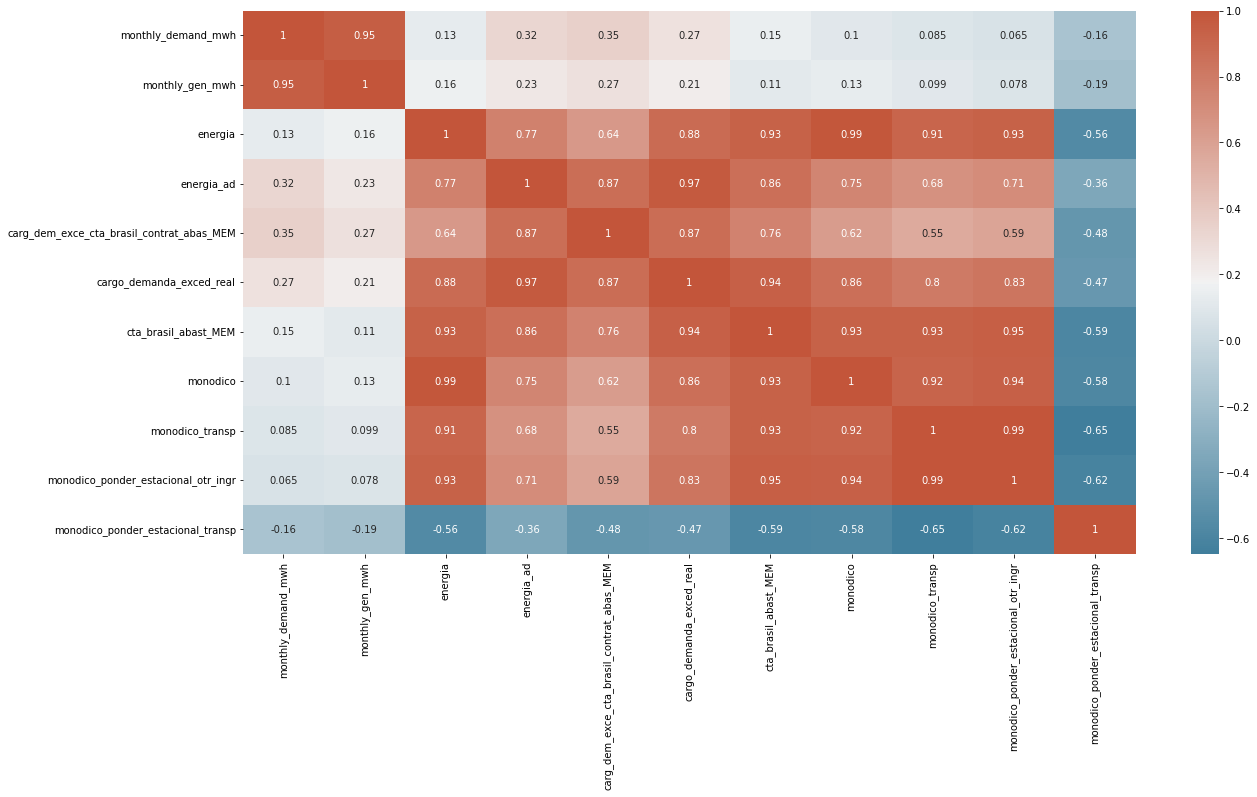

In [306]:
#method{‘pearson’, ‘kendall’, ‘spearman’} default pearson
corr = df_dataset.corr(method='pearson')
%matplotlib inline
plt.figure(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#sns.heatmap(corr, cmap="Greens", annot=True)
sns.heatmap(corr, cmap=cmap, annot=True)
plt.show()

### Correlaciones No lineales

In [308]:
# Plotting the PPS matrix:
# (This needs some minor preprocessing because seaborn.heatmap unfortunately does not accept tidy data)
# pip install ppscore
import ppscore as pps

matrix_df = pps.matrix(df_dataset)[['x', 'y', 'ppscore']]\
    .pivot(columns='x', index='y', values='ppscore')

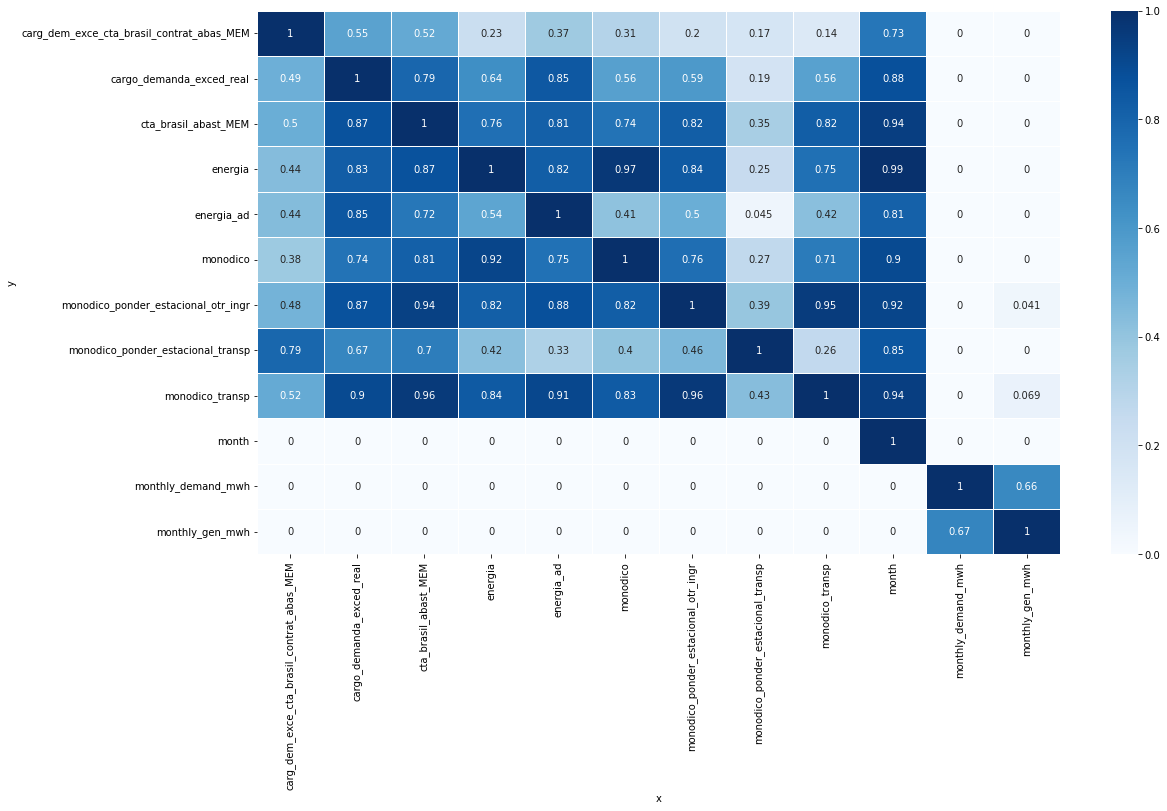

In [309]:
plt.figure(figsize=(18, 10))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True);

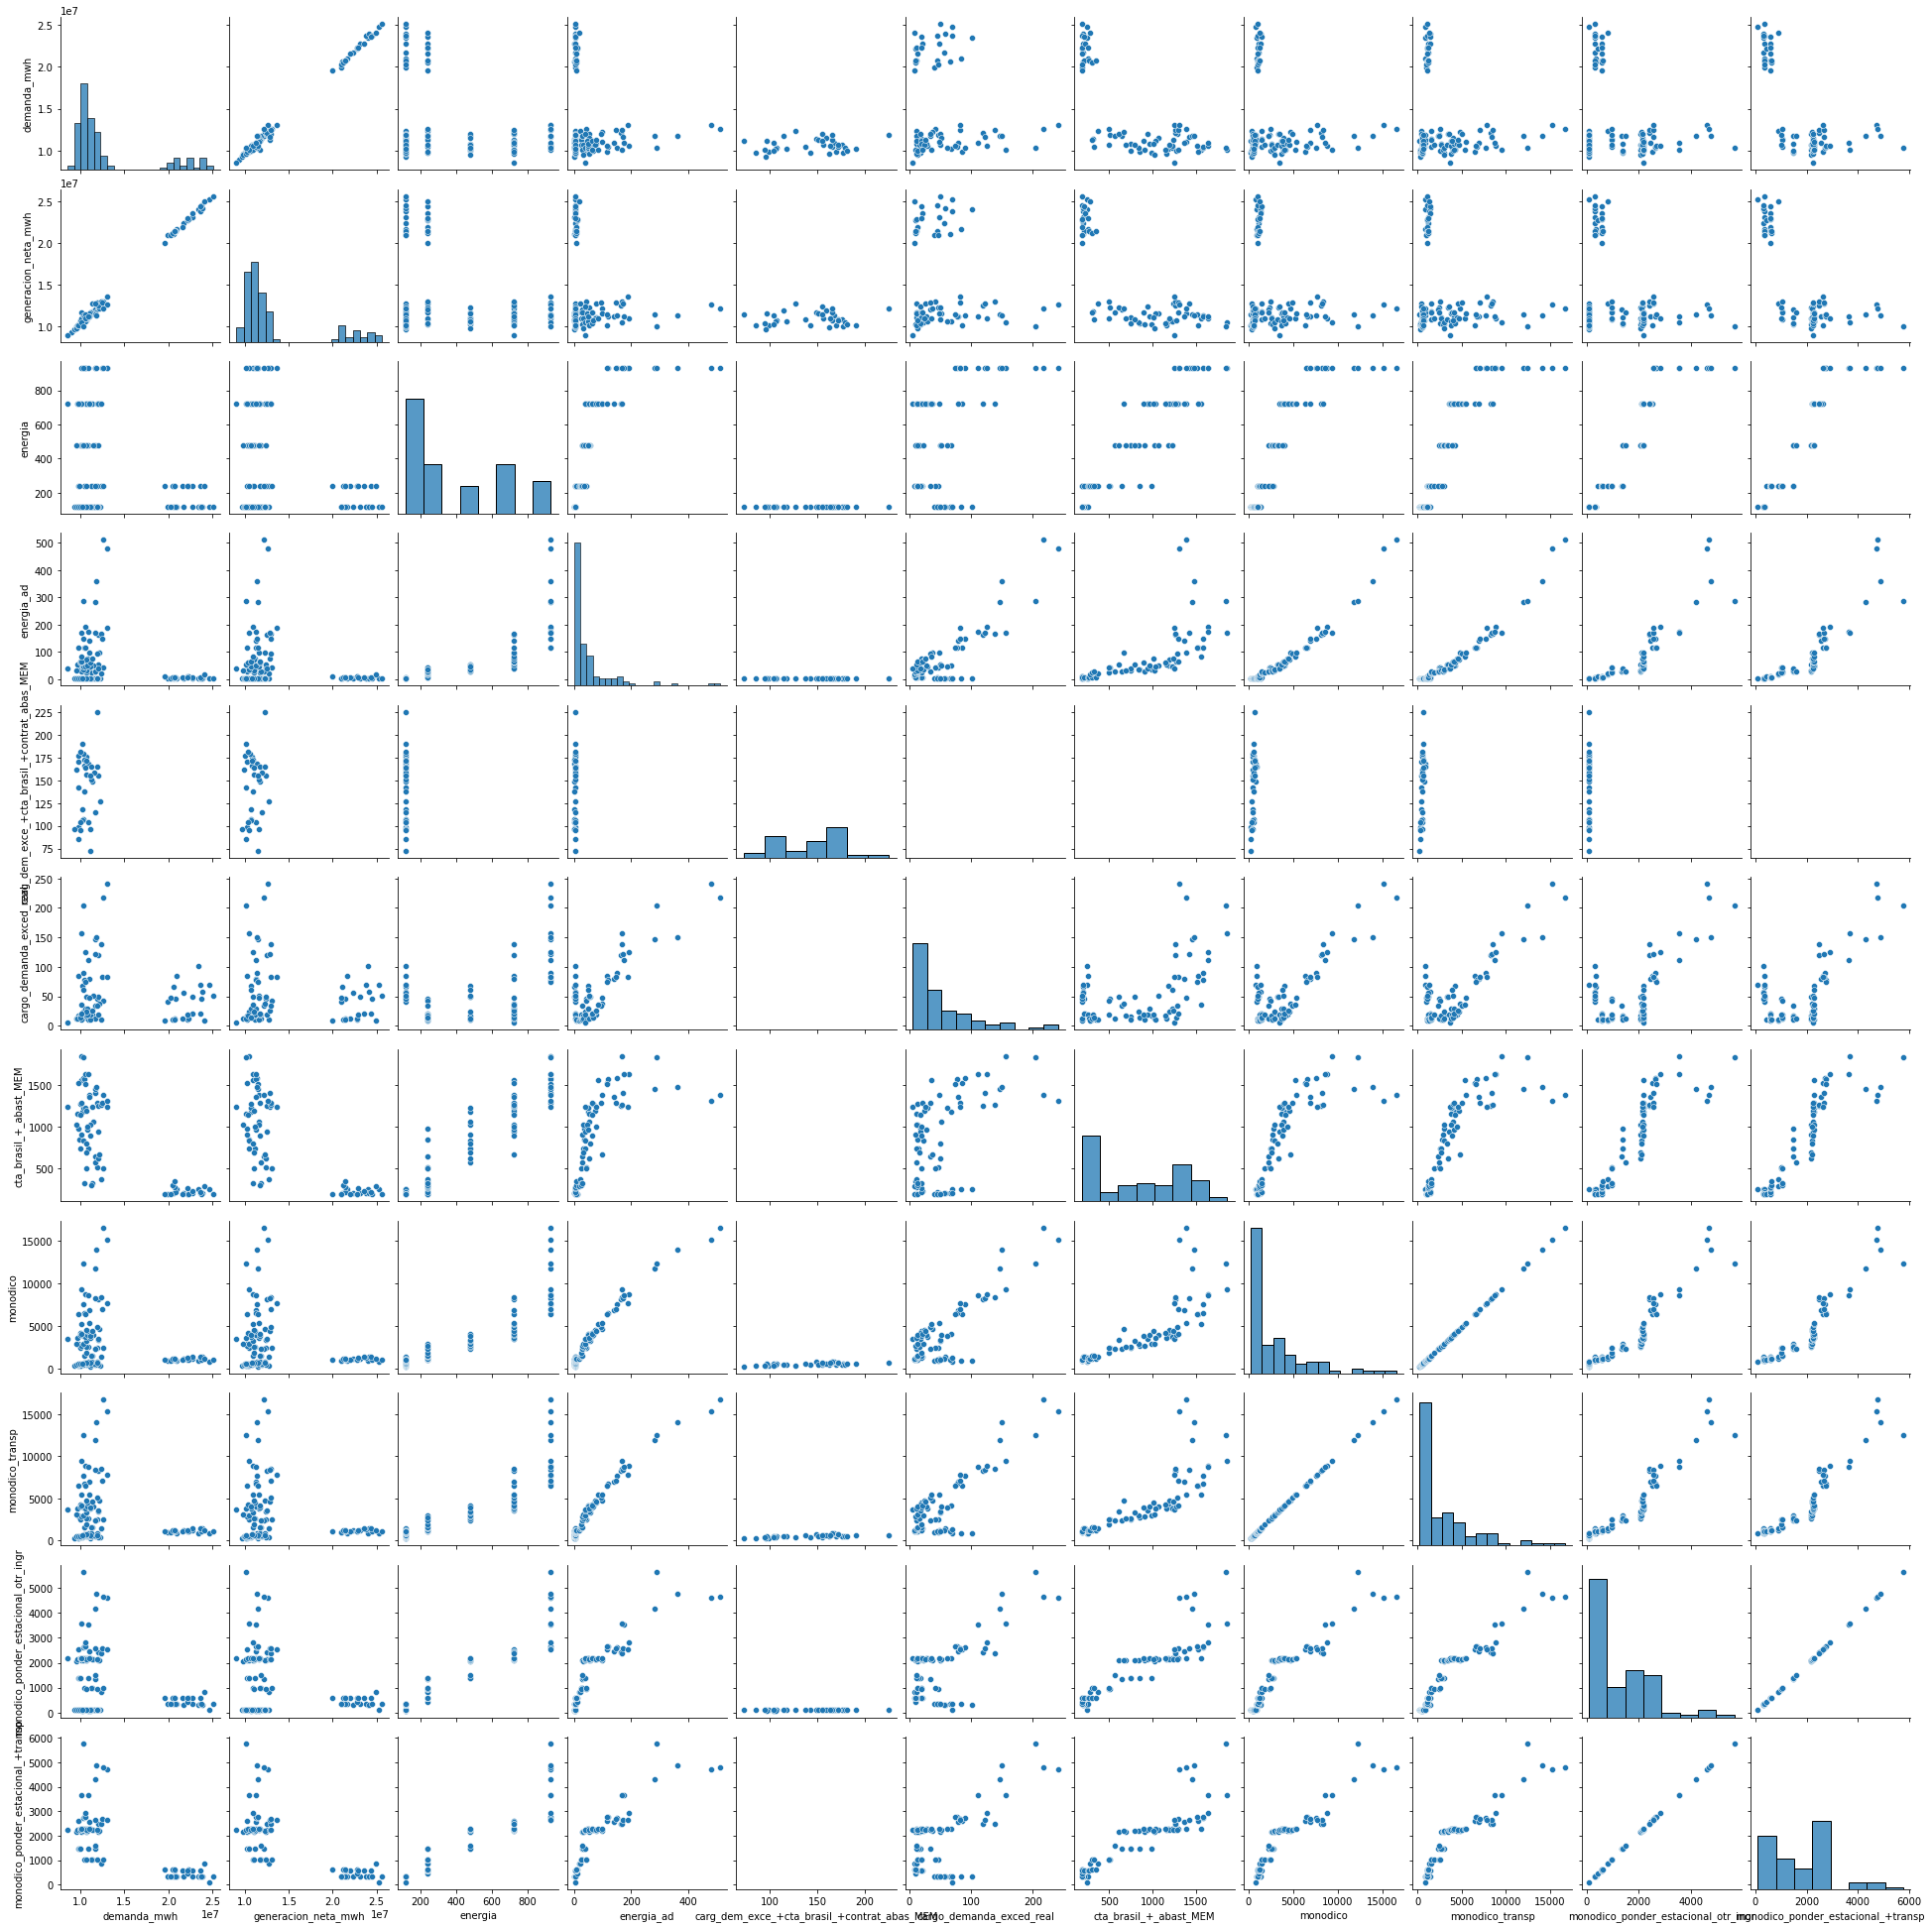

In [118]:
# Create the default pairplot
sns.pairplot(df_dataset)

In [ ]:
# https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/
# https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/
# https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
# https://www.analyticsvidhya.com/blog/2022/05/5-python-libraries-for-time-series-analysis/
# https://www.analyticsvidhya.com/blog/2022/04/an-end-to-end-guide-on-time-series-forecasting-using-fbprophet/


# Forecasting
# LSTM forecasting
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
A powerful type of neural network designed to handle sequence dependence is called recurrent neural networks. The Long Short-Term Memory network or LSTM network is a type of recurrent neural network used to address time-series prediction problem.<br>
Develop a LSTM network for regression, window and time-step based framing of time series prediction problems.
* https://arxiv.org/abs/1507.06947

## LSTMs for Univariate Time Series Forecasting
Argentina electricity demand prediction problem. This is a problem where, given a year and a month, the task is to predict the argentinian electricity demand in MWh. The data ranges from January 2012 to Sept 2022, or almost 12 years, with 129 observations.

# LSTM Training

In [ ]:
#!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# We are not interested in the date, given that each observation is separated by the same interval (hourly) 
# We build an univariate dataset:
df_hist_univar = df_demanda[['monthly_demand_mwh']]

In [ ]:
# It is a good idea to fix the random number seed to ensure our results are reproducible.
tf.random.set_seed(786)

In [ ]:
# LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
# It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. 
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(df_hist_univar)

## Experiment 1

In [ ]:
# Train - Test separation
# With time series data, the sequence of values is important. 
# A simple method that we can use is to split the ordered dataset into train and test datasets. 
# The code below calculates the index of the split point and separates the data into the training ys 
# with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

# split into train and test sets
train_size = int(len(y) * 0.7)
test_size = len(y) - train_size
train, test = y[0:train_size,:], y[train_size:len(y),:]
print(len(train), len(test))

90 39


In [ ]:
# The LSTM network expects the input data (X) to be provided with a specific array structure 
# in the form of: [samples, time steps, features].
# We can write a simple function to convert our single column of data into a two-column dataset: 
# the first column containing this hour’s (t) electricity demand and the second column containing next hour’s (t+1) 
# electricity demand, to be predicted.
def create_dataset(y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(y)-look_back-1):
        a = y[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(y[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# The function takes two arguments: the y, and the look_back, which is the number of previous time steps to use as 
# input variables to predict the next time period — in this case defaulted to 1.
# This will create a y where X is the demand at a given time (t) and Y is the demand at the next time (t + 1).

In [ ]:
# reshape into X=t and Y=t+1
look_back = 24 # look back 2 years
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. 
# We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:
# reshape input to be [samples, time steps, features]
# 1 stands for the time period between data.
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# LTSM newtword design
# The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a 
# single value prediction. 
# The default sigmoid activation function is used for the LSTM blocks. 
# The network is trained for 100 epochs and a batch size of 1 is used.

# Predict more than 1 future value: https://stackoverflow.com/questions/69906416/forecast-future-values-with-lstm-in-python

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
#verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar per epoch, 2 = one line per epoch

Epoch 1/100
65/65 - 2s - loss: 0.1552 - 2s/epoch - 38ms/step
Epoch 2/100
65/65 - 0s - loss: 0.0271 - 197ms/epoch - 3ms/step
Epoch 3/100
65/65 - 0s - loss: 0.0240 - 175ms/epoch - 3ms/step
Epoch 4/100
65/65 - 0s - loss: 0.0225 - 153ms/epoch - 2ms/step
Epoch 5/100
65/65 - 0s - loss: 0.0203 - 147ms/epoch - 2ms/step
Epoch 6/100
65/65 - 0s - loss: 0.0185 - 181ms/epoch - 3ms/step
Epoch 7/100
65/65 - 0s - loss: 0.0171 - 175ms/epoch - 3ms/step
Epoch 8/100
65/65 - 0s - loss: 0.0157 - 126ms/epoch - 2ms/step
Epoch 9/100
65/65 - 0s - loss: 0.0141 - 142ms/epoch - 2ms/step
Epoch 10/100
65/65 - 0s - loss: 0.0138 - 105ms/epoch - 2ms/step
Epoch 11/100
65/65 - 0s - loss: 0.0135 - 100ms/epoch - 2ms/step
Epoch 12/100
65/65 - 0s - loss: 0.0118 - 105ms/epoch - 2ms/step
Epoch 13/100
65/65 - 0s - loss: 0.0116 - 114ms/epoch - 2ms/step
Epoch 14/100
65/65 - 0s - loss: 0.0115 - 207ms/epoch - 3ms/step
Epoch 15/100
65/65 - 0s - loss: 0.0110 - 171ms/epoch - 3ms/step
Epoch 16/100
65/65 - 0s - loss: 0.0106 - 145ms/epoc

In [ ]:
model.save('lstm_model_monthly_24.h5')  # creates a HDF5 file. Load with from keras.models import load_model

In [ ]:
# Once the model is fit, we can estimate the performance of the model on the train and test datasets. 
# This will give us a point of comparison for new models.
# Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units 
# as the original data -pre normalized data.

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions --> to see data on its original scale (pre-normalized)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 28ms/step
Train Score: 349816.87 RMSE
Test Score: 528600.64 RMSE


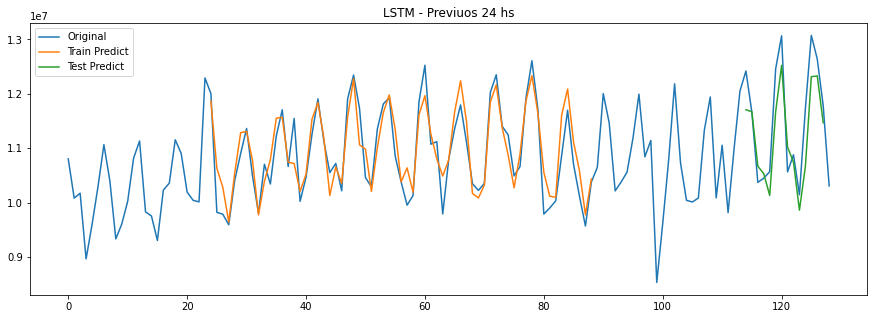

In [ ]:
trainPredictPlot = np.empty_like(y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(y)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(y)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15, 5))
plt.plot(scaler.inverse_transform(y), label='Original')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('LSTM - Previuos 24 Months')
plt.legend()
plt.show()

In [ ]:
model = load_model('lstm_model_monthly_24.h5')

In [ ]:
# [6] Generate forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, 1, n_lookback)

#X_ = np.reshape(X_, (X_.shape[0], 1, X_.shape[1]))

Y_ = model.predict(X_)#.reshape(-1, 1)
Y_ = scaler.inverse_transform([Y_])

1/1 [==============================] - 0s 44ms/step


ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
# [7] Plot
n_forecast = 24
df_past = df_demanda[['month', 'monthly_demand_mwh']]
df_past.rename(columns={'monthly_demand_mwh': 'Actual'}, inplace=True)
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['month', 'Actual', 'Forecast'])
df_future['month'] = pd.date_range(start=df_past['month'].iloc[-1], freq='1MS', periods=n_forecast+1)[1:]
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('month')

# plot the results
results.plot(title='Energy Demand Forecast')

ValueError: Length of values (1) does not match length of index (24)

## Experiment 2

In [ ]:
# [3] Generate the input and output sequences
n_lookback = 24  # length of input sequences (lookback period)
n_forecast = 24  # length of output sequences (forecast period)
X = []
Y = []
for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])
X = np.array(X)
Y = np.array(Y)

In [ ]:
# [4] fit the model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
print('WAIT until I fit model.') # ~ 12 min de ejecución
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

WAIT until I fit model.


In [ ]:
# [5] Persist the model
model.save('lstm_model_monthly_24_exp_2.h5')  # creates a HDF5 file. Load with from keras.models import load_model

In [ ]:
# [6] Generate forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 [==============================] - 1s 1s/step


<AxesSubplot:title={'center':'Energy Demand Forecast'}, xlabel='month'>

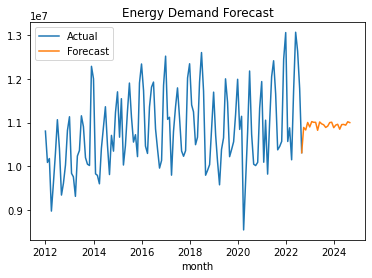

In [ ]:
# [7] Plot
df_past = df_demanda[['month', 'monthly_demand_mwh']]
df_past.rename(columns={'monthly_demand_mwh': 'Actual'}, inplace=True)
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['month', 'Actual', 'Forecast'])
df_future['month'] = pd.date_range(start=df_past['month'].iloc[-1], freq='1MS', periods=n_forecast+1)[1:]
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('month')

# plot the results
results.plot(title='Energy Demand Forecast')